In [ ]:
!pip install phe

In [ ]:
!pip install scikit-commpy

In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
import random as rn
import sys
import matplotlib.pyplot as plt
from phe import paillier
import commpy.modulation as mod
from commpy.modulation import QAMModem, mimo_ml, bit_lvl_repr, max_log_approx, PSKModem, Modem
import commpy.channels as ch

In [37]:
def get_data(N, M):
    #Generating the dataset of N samples
    pre_data = np.random.randint(M,size=N)
    
    data = []
    #Generate One_hots Encoded data
    for i in pre_data:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)
    data = np.array(data)
    return data

In [38]:
M = 16 #no. of messages 
k = int(np.log2(M)) #no. of information bits per message
n_channel = 7 # Number of real channel uses per message
print('M:{} k:{} N_channel:{}'.format(M,k,n_channel))

M:16 k:4 N_channel:7


In [39]:
N = 100000
data = get_data(N, M)
N_val = 10000
val_data = get_data(N_val, M)
print('data:',data[50],'val_data:',val_data[25])

data: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] val_data: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [40]:
#Transmitter
input_signal = Input(shape=(M,))
transmitter1 = Dense(M, activation='relu')(input_signal)
transmitter2 = Dense(n_channel, activation='linear')(transmitter1)
transmitter = BatchNormalization()(transmitter2)

#Channel
R = 4/7
EbNo_train = 5.01187 #  coverted 7 db of EbNo
Channel = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(transmitter)

#Receiver
receiver1 = Dense(M, activation='relu')(Channel)
receiver = Dense(M, activation='softmax')(receiver1)
#keras.utils.plot_model(autoencoder, show_shapes=True)

In [41]:
#Compiling the model 
autoencoder = Model(input_signal, receiver)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')
#keras.utils.plot_model(autoencoder, show_shapes=True)

In [42]:
print (autoencoder.summary())

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 119       
_________________________________________________________________
batch_normalization_1 (Batch (None, 7)                 28        
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 7)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 16)               

In [43]:
autoencoder.fit(data, data,
                epochs=20,
                batch_size=100,
                validation_data=(val_data, val_data))

Epoch 1/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3964 - val_loss: 0.0040
Epoch 2/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0054 - val_loss: 5.7530e-04
Epoch 3/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 1.6844e-04
Epoch 4/20
1000/1000 [==============================] - 1s 1ms/step - loss: 6.3670e-04 - val_loss: 6.2235e-05
Epoch 5/20
1000/1000 [==============================] - 1s 1ms/step - loss: 3.0465e-04 - val_loss: 2.6586e-05
Epoch 6/20
1000/1000 [==============================] - 1s 1ms/step - loss: 1.5436e-04 - val_loss: 1.1985e-05
Epoch 7/20
1000/1000 [==============================] - 1s 1ms/step - loss: 1.0819e-04 - val_loss: 7.2356e-06
Epoch 8/20
1000/1000 [==============================] - 1s 1ms/step - loss: 5.4157e-05 - val_loss: 2.4029e-06
Epoch 9/20
1000/1000 [==============================] - 1s 1ms/step - loss: 2.9446e-05 - val_loss: 1.2154e-06
Epoch 10/20
1000/1000 [===




**LOADING THE MODEL AND TESTING IT ON NEW DATA**




In [44]:
#Creating Transmitter model
Transmitter = Model(input_signal, transmitter)
encoded_input = Input(shape=(n_channel,))

#Creating Receiver model
deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
Receiver = Model(encoded_input, deco)

In [45]:
#Creating Test Data

N_test = 50000
test_label = np.random.randint(M,size=N_test)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)
print(test_data[10])
print(test_data.flatten().shape)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(800000,)


In [46]:
#Tesing the autoencoder model for new data
encoded_signal = Transmitter.predict(test_data[10:11]) 
final_signal = encoded_signal 
output = np.squeeze(Receiver.predict(final_signal).astype(int))
print('Output data for autoencoder:',output)

Output data for autoencoder: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [49]:
#Data for qpsk
data_qpsk = test_data[10].astype(int)
print(data_qpsk)

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


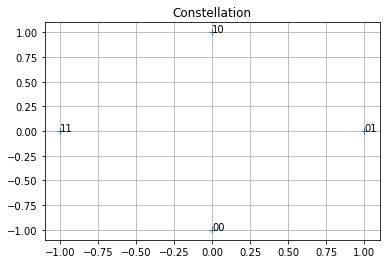


Symbols 
 [6.123234e-17-1.j 6.123234e-17-1.j 6.123234e-17-1.j 6.123234e-17+1.j
 6.123234e-17-1.j 6.123234e-17-1.j 6.123234e-17-1.j 6.123234e-17-1.j]

Signal 
 [-0.39177251-0.77899941j -0.34402887-1.01090085j -0.03793471-1.02210567j
 -0.06949411+1.2485913j  -0.161005  -0.89237309j -0.28851045-1.03672011j
  0.2610185 -1.05566896j -0.40308093-1.27427119j]

Output for qpsk: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [56]:
#Same data for qpsk
#Modulation
modem = mod.PSKModem(4) 
modem.plot_constellation()

#Symbol generation and AWGN noise addition
symbols = modem.modulate(input_bits=data_qpsk)
print('\nSymbols' ,'\n',symbols)
snr = 2 * 5.01187                   #SNR = Bits_per_Symbol * Eb/No
signal = ch.awgn(symbols, snr)
print('\nSignal','\n',signal)

#Demodulation
bits=modem.demodulate(signal, 'hard',noise_var=0)
print('\nOutput for qpsk:', bits)

**Evaluation of the model**

In [57]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [58]:
#Evaluation of Autoencoder
EbNodB_range = list(frange(-4,4,0.5))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    noise = noise_std * np.random.randn(N_test,n_channel)
    encoded_signal = Transmitter.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  Receiver.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / N_test 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

SNR: -4 BER: 0.07144
SNR: -3.5 BER: 0.05216
SNR: -3.0 BER: 0.03586
SNR: -2.5 BER: 0.02446
SNR: -2.0 BER: 0.01598
SNR: -1.5 BER: 0.00838
SNR: -1.0 BER: 0.00486
SNR: -0.5 BER: 0.003
SNR: 0.0 BER: 0.00146
SNR: 0.5 BER: 0.0005
SNR: 1.0 BER: 0.00038
SNR: 1.5 BER: 8e-05
SNR: 2.0 BER: 2e-05
SNR: 2.5 BER: 0.0
SNR: 3.0 BER: 0.0
SNR: 3.5 BER: 0.0


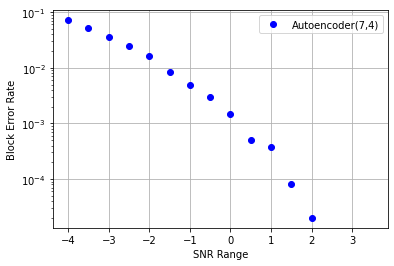

In [59]:
import matplotlib.pyplot as plt
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(7,4)')
#plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)

(1e-05, 1)

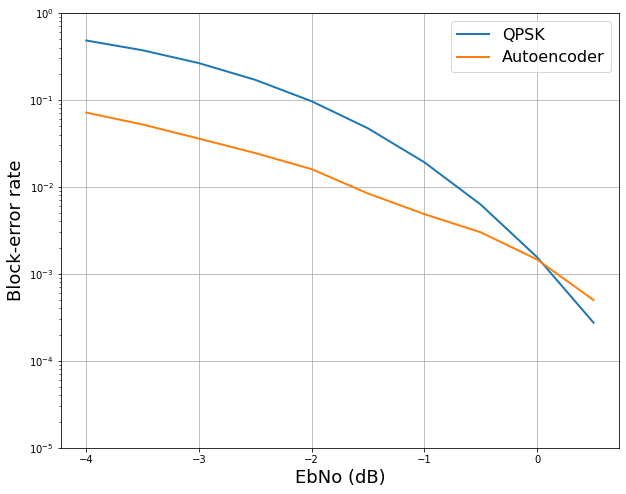

In [61]:
ber2 = ber[:10] 
EbNodB_range2 = EbNodB_range[:10]

BLER_QPSK_k8n8 = np.array([4.818329E-01, 3.720104E-01, 2.645386E-01, 1.698987E-01, 9.636992E-02, 4.703772E-02, 1.914436E-02, 6.244719E-03, 1.551032E-03, 2.745986E-04, 3.194809E-05, 2.384186E-06, 0.000000E+00, 0.000000E+00, 0.000000E+00])

plt.figure(figsize=(10,8))
plt.plot(EbNodB_range2, BLER_QPSK_k8n8[:10], linewidth=2.0)
plt.plot(EbNodB_range2, ber2, linewidth=2.0)
plt.legend(['QPSK', 'Autoencoder'], prop={'size': 16}, loc='upper right');
plt.yscale('log')
plt.xlabel('EbNo (dB)', fontsize=18)
plt.ylabel('Block-error rate', fontsize=18)
plt.grid(True)
plt.ylim([1e-5,1])